# NCAR JupyterHub Large Data Example Notebook

*Note: If you do not have access to the NCAR machine, please look at the AWS-LENS example notebook instead.*

This notebook demonstrates how to compare large datasets on glade with ldcpy.  In particular, we will look at data from CESM-LENS1 project (http://www.cesm.ucar.edu/projects/community-projects/LENS/data-sets.html). In doing so, we will start a DASK client from Jupyter.  This notebook is meant to be run on NCAR's JupyterHub (https://jupyterhub.ucar.edu). We will use a subset of the CESM-LENS1 data on glade is located in /glade/p/cisl/asap/ldcpy_sample_data. 

We assume that you have a copy of the ldcpy code on NCAR's glade filesystem, obtained via:<br>
    `git clone https://github.com/NCAR/ldcpy.git`

When you launch your NCAR JupyterHub session, you will need to indicate a machine (Casper) and then you will need your charge account.  You can then launch the session and navigate to this notebook.  

Here's good resource for using NCAR's JupyterHub:<br>
https://ncar-hackathons.github.io/jupyterlab-tutorial/jhub.html)


**You need to run your notebook with the "cmip6-201910" kernel (choose from the dropdown in the upper left.)**


Note that the compressed data that we are using was generated for this paper:

Allison H. Baker, Dorit M. Hammerling, Sheri A. Mickelson, Haiying Xu, Martin B. Stolpe, Phillipe Naveau, Ben Sanderson, Imme Ebert-Uphoff, Savini Samarasinghe, Francesco De Simone, Francesco Carbone, Christian N. Gencarelli, John M. Dennis, Jennifer E. Kay, and Peter Lindstrom, “Evaluating Lossy Data Compression on Climate Simulation Data within a Large Ensemble.”  Geoscientific Model Development, 9, pp. 4381-4403, 2016 
(https://gmd.copernicus.org/articles/9/4381/2016/)




## Setup
First, let's set up our environment.  You will need to modify the path to indicate where you have cloned ldcpy.

In [1]:
#Make sure you are using the cmpi6-2019.10 kernel (see above)

#Add ldcpy root to system path (MODIFY FOR YOUR LDCPY CODE)
import sys
sys.path.insert(0,'/glade/u/home/abaker/repos/ldcpy')
import ldcpy

#Display output of plots directly in Notebook
%matplotlib inline
#Automatically reload module if it is editted
%reload_ext autoreload
%autoreload 2

#silence warnings
import warnings
warnings.filterwarnings("ignore")


### Connect to DASK distributed cluster (Casper uses slurm):

In [3]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(memory="40GB", cores=4, processes=1, walltime="00:45:00", project="NIOW0001")
#scale as needed
cluster.adapt(minimum_jobs=1, maximum_jobs=35)
cluster

In [4]:
# Look at the job script
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -A NIOW0001
#SBATCH -n 1
#SBATCH --cpus-per-task=4
#SBATCH --mem=38G
#SBATCH -t 00:45:00
#SBATCH -C skylake

/ncar/usr/jupyterhub/envs/cmip6-201910/bin/python -m distributed.cli.dask_worker tcp://10.12.205.27:40458 --nthreads 4 --memory-limit 40.00GB --name name --nanny --death-timeout 60 --interface ib0



In [5]:
# Connect client to the remote dask workers
client = Client(cluster)
client

Client Scheduler: tcp://10.12.205.27:40458 Dashboard: http://10.12.205.27:8787/status,Cluster Workers: 1 Cores: 4 Memory: 40.00 GB


## The sample data on glade

In /glade/p/cisl/asap/ldcpy_sample_data on glade, we have TS (surface temperature), PRECT (precipiation rate), and PS (surface pressure) data from CESM-LENS1. These all all 2D variables.  TS and PRECT have daily output, and PS has monthly output.  We have the compressed and original versions of all these variables that we would like to compare.

First we list what is in this directory (two subdirectories):

In [6]:
#list directory contents
import os
os.listdir('/glade/p/cisl/asap/ldcpy_sample_data')

['lossy', 'orig']

Now we look at the contents of each subdirectory.  We have 6 files in each, consisting of 2 different timeseries files for each variable (1920-2005 and 2006-2080).

In [7]:
#list lossy directory contents (files that have been lossy compressed and reconstructed)
lossy_files = os.listdir('/glade/p/cisl/asap/ldcpy_sample_data/lossy')
lossy_files

['c.TS.daily.19200101-20051231.nc',
 'c.PRECT.daily.20060101-20801231.nc',
 'c.PS.monthly.200601-208012.nc',
 'c.PRECT.daily.19200101-20051231.nc',
 'c.TS.daily.20060101-20801231.nc',
 'c.PS.monthly.192001-200512.nc']

In [8]:
#list orig (i.e., uncompressed) directory contents
orig_files = os.listdir('/glade/p/cisl/asap/ldcpy_sample_data/orig')
orig_files

['PRECT.daily.20060101-20801231.nc',
 'PS.monthly.192001-200512.nc',
 'PRECT.daily.19200101-20051231.nc',
 'TS.daily.20060101-20801231.nc',
 'PS.monthly.200601-208012.nc',
 'TS.daily.19200101-20051231.nc']

We can look at how big these files are...

In [9]:
print ('Original files')
for f in orig_files:
    print(f ," ", os.stat('/glade/p/cisl/asap/ldcpy_sample_data/orig/' + f).st_size/1e9, 'GB')

Original files
PRECT.daily.20060101-20801231.nc   4.999594482 GB
PS.monthly.192001-200512.nc   0.129124682 GB
PRECT.daily.19200101-20051231.nc   5.732874059 GB
TS.daily.20060101-20801231.nc   3.504791459 GB
PS.monthly.200601-208012.nc   0.112432632 GB
TS.daily.19200101-20051231.nc   4.042316511 GB


### Open datasets

First, let's look at the original and reconstructed files for the monthly surface Pressure (PS) data for 1920-2006.

In [10]:
#load the first 86 years of montly surface pressure into a collection
ds_PS = ldcpy.open_datasets(["PS"],
                            ['/glade/p/cisl/asap/ldcpy_sample_data/orig/PS.monthly.192001-200512.nc', 
                                 '/glade/p/cisl/asap/ldcpy_sample_data/lossy/c.PS.monthly.192001-200512.nc'],
                         ['orig', 'lossy'], chunks={'time': 5})
ds_PS

chunks set to (by user)  {'time': 5}
dataset size in GB 0.46



,Array,Chunk
Bytes,16.51 kB,80 B
Shape,"(1032, 2)","(5, 2)"
Count,1245 Tasks,207 Chunks
Type,object,numpy.ndarray
,Array,Chunk
Bytes,4.13 kB,20 B
Shape,"(1032,)","(5,)"
Count,1245 Tasks,207 Chunks
Type,int32,numpy.ndarray
,Array,Chunk


## Data comparison

Now we use the ldcpy package features to compare the data.

### Surface Pressure 
Let's look at the comparison statistics at the first timeslice for PS.

In [11]:
ldcpy.print_stats(ds_PS, 'PS', 'orig', 'lossy', time=0)

Comparing orig data (set1) to lossy data (set2)
(192, 288)
 
mean set1: 9.6750e+04
mean set2: 9.6734e+04
mean diff: 1.5806e+01
 
variance set1: 8.4254e+07
variance set2: 8.4249e+07
 
standard deviation set1: 9.1790e+03
standard deviation set2: 9.1787e+03
 
max value set1: 1.0299e+05
max value set2: 1.0298e+05
min value set1: 5.1967e+04
min value set2: 5.1952e+04
 
max abs diff: 3.1992e+01
min abs diff: 0.0000e+00
mean abs diff: 1.5806e+01
mean squared diff: 2.4983e+02
root mean squared diff: 1.8303e+01
normalized root mean squared diff: 3.5870e-04
normalized max pointwise error: 6.2698e-04
pearson correlation coefficient: 1.0000e+00
ks p-value: 1.4540e-02
spatial relative error(% > 0.0001): 6.9085e+01


Now we compare the mean PS values across time in the orig and lossy datasets.

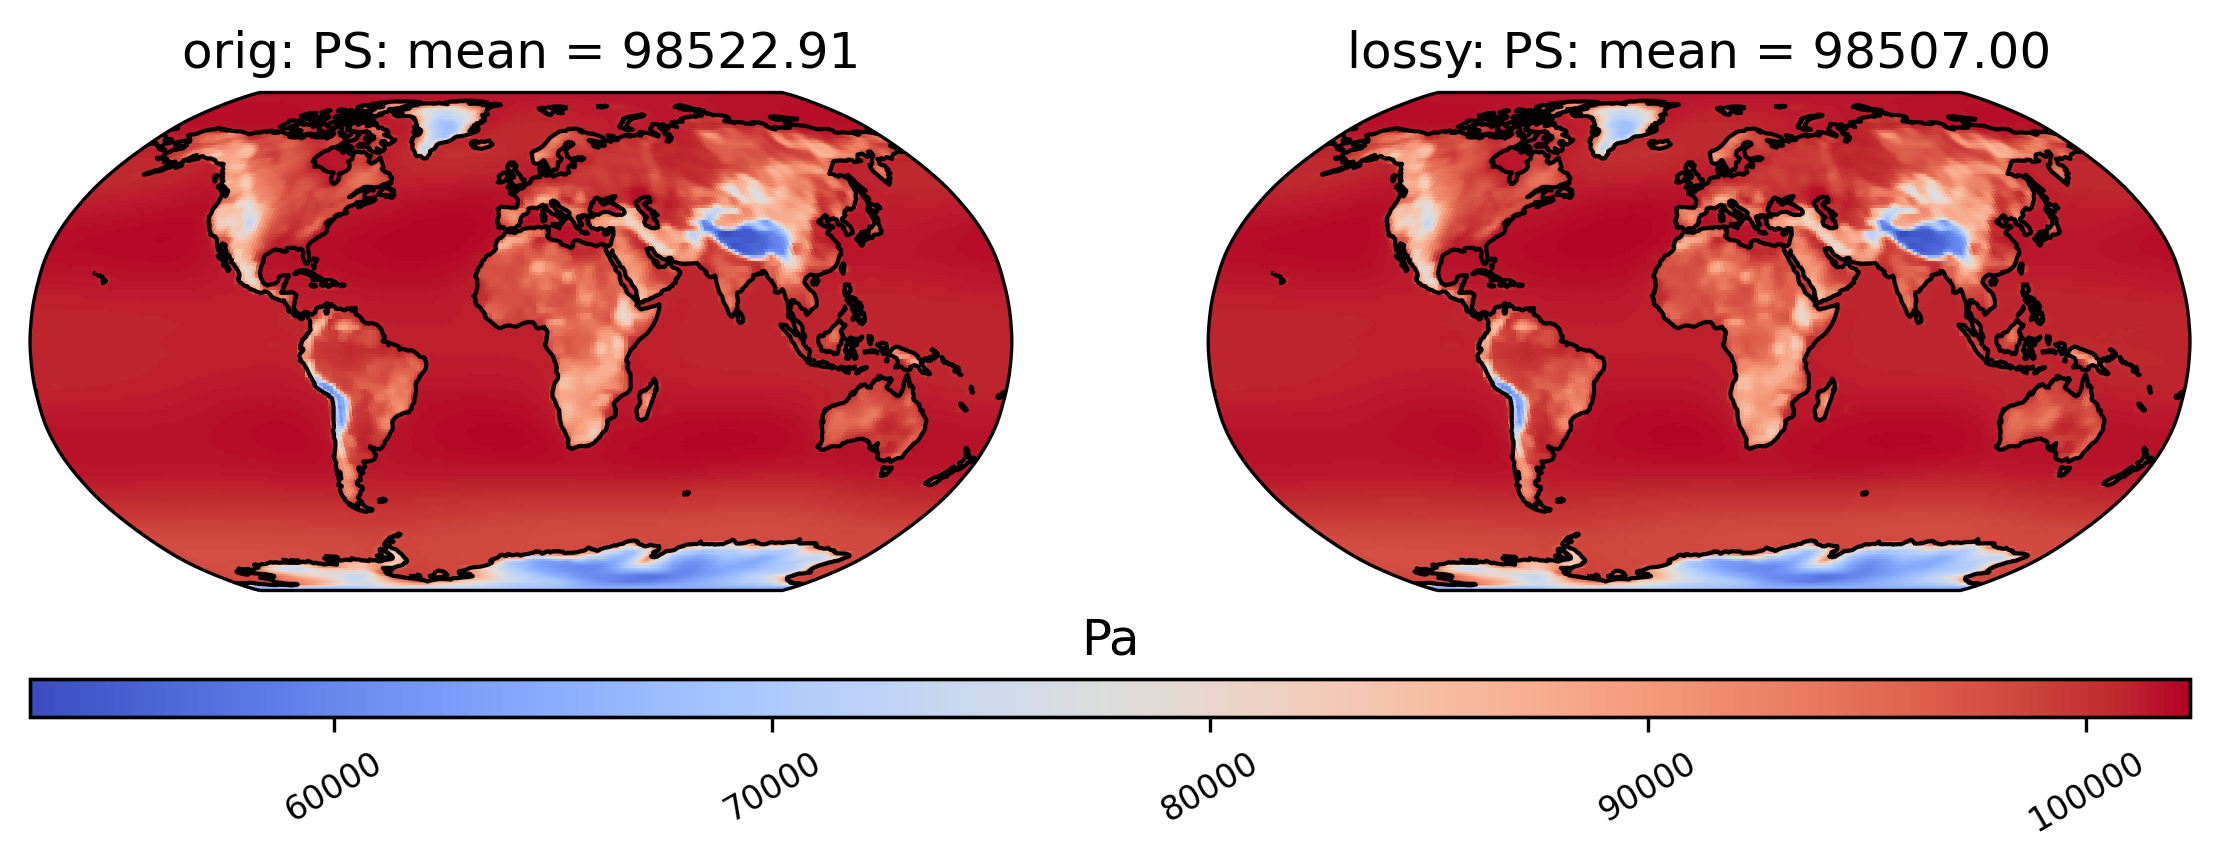

In [12]:
# comparison between mean PS values in ds_PS orig and lossy datasets
ldcpy.plot(ds_PS, "PS", set1='orig', metric='mean', set2='lossy', plot_type="spatial_comparison")

Now we instead show the difference plot for the above plots.

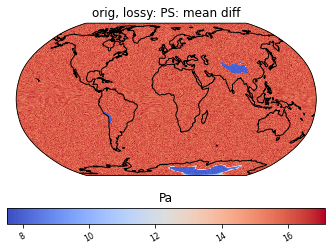

In [14]:
# diff between mean PS values in ds_PS orig and lossy datasets
ldcpy.plot(ds_PS, "PS", set1='orig', metric='mean', set2='lossy', metric_type='diff', plot_type="spatial")

We can also look at mean differences over time.  Here we are looking at the spatial averages and then grouping by day of the year.

IndexError: list index out of range

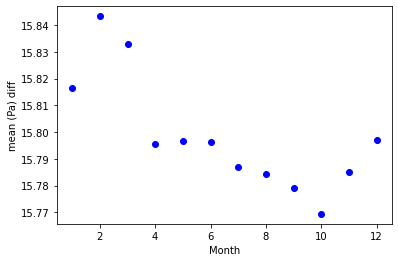

In [16]:
# Time-series plot of mean PS differences between ds_PS orig and ds_PS lossy datasets grouped by month of year
ldcpy.plot(ds_PS, "PS", set1='orig', metric='mean', plot_type="time_series", 
           set2="lossy", group_by="time.month", metric_type="diff")

### Surface Temperature

Now let's open the daily surface temperature (TS) data for 1920-2006. These are larger files than the monthly PS data.

In [ ]:
#load the first 86 years of daily surface temperature (TS) data
ds_TS = ldcpy.open_datasets(["TS"],
                            ['/glade/p/cisl/asap/ldcpy_sample_data/orig/TS.daily.19200101-20051231.nc', 
                                 '/glade/p/cisl/asap/ldcpy_sample_data/lossy/c.TS.daily.19200101-20051231.nc'],
                         ['orig', 'lossy'], chunks={'time': 5})

Now let's look more closely at this TS data.

In [ ]:
ds_TS

Look at the first time slice statistics:

In [ ]:
ldcpy.print_stats(ds_TS, 'TS', 'orig', 'lossy', time=0)

In [ ]:
Now we compare mean TS over time:

In [ ]:
# comparison between mean TS values in ds_TS orig and lossy datasets
ldcpy.plot(ds_TS, "TS", set1='orig', metric='mean', set2='lossy', plot_type="spatial_comparison")

In [ ]:
cluster.close()
client.close()